In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [5]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [6]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [10]:
# Save references to each table
Msrmnts = Base.classes.measurement
Station = Base.classes.station

In [11]:
# Create our session (link) from Python to the DB
session = Session(engine)

In [12]:
inspector = inspect(engine)
columns = inspector.get_columns('measurement')
for c in columns:
    print(c['name'], c["type"])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


# Exploratory Precipitation Analysis

In [27]:
# Find the most recent date in the data set.

#session.query(Msrmnts.date).order_by(Msrmnts.date.desc()).first()
d1=session.query(func.max(Msrmnts.date)).first()
d1

('2017-08-23')

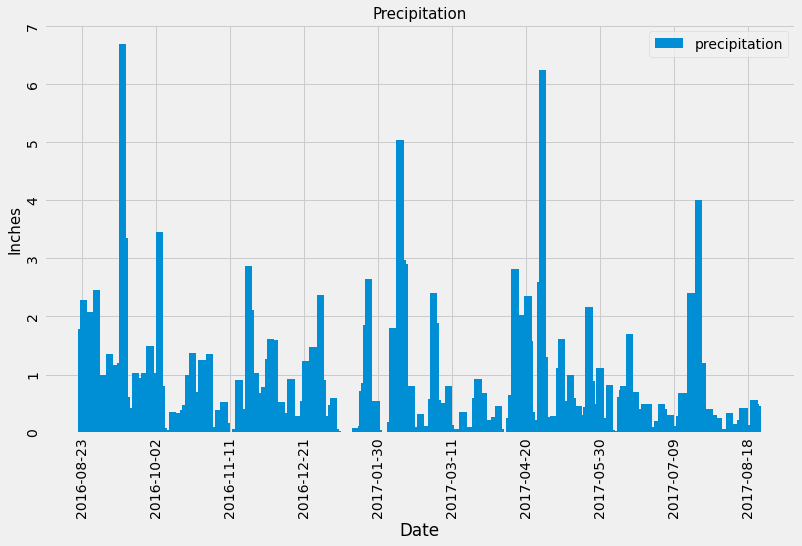

In [28]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 

# Calculate the date one year from the last date in data set.
max_d = dt.datetime.strptime(d1[0], "%Y-%m-%d")
query_date = max_d  - dt.timedelta(days=366)
#print("Query Date: ", query_date)

# Perform a query to retrieve the data and precipitation scores
results= session.query(Msrmnts.date,Msrmnts.prcp).\
            filter(Msrmnts.date > query_date).\
            all()
           #order_by(Msrmnts.date).all()

# Save the query results as a Pandas DataFrame and set the index to the date column
df = pd.DataFrame(results, columns=['Date', 'Precipitation']).dropna()

df.set_index('Date', inplace=True)

# Sort the dataframe by date
df.sort_values(by='Date', inplace = True)

# Use Pandas Plotting with Matplotlib to plot the data

# bar plot with matplotlib
fig, ax = plt.subplots()
ax.bar(df.index, df['Precipitation'], width=4)
ax.set_xlabel("Date")
ax.set_ylabel("Inches", size=15)
ax.xaxis.set_major_locator(plt.MaxNLocator(11))
#ax.set_xticklabels(ax.get_xticks(), rotation = 90)
ax.tick_params(labelrotation=90)
plt.legend(["precipitation"])
plt.title("Precipitation", size=15)
fig.set_figheight(7)
fig.set_figwidth(12)
plt.show()



In [29]:
# Use Pandas to calcualte the summary statistics for the precipitation data
df.describe()


,Precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [31]:
columns = inspector.get_columns('station')
for c in columns:
    print(c['name'], c["type"])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [32]:
# Design a query to calculate the total number stations in the dataset
#session.query((Station.station)).all()
session.query(func.count(Station.station)).all()

[(9)]

In [33]:
#session.query(Msrmnts.station).all()

In [34]:
# Design a query to find the most active stations (i.e. what stations have the most rows?)
# List the stations and the counts in descending order.

count_ = func.count('*')
session.query(Msrmnts.station,count_).\
              group_by(Msrmnts.station).order_by(count_.desc()).all()




[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [35]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
station_temp = session.query(Msrmnts.station,func.min(Msrmnts.tobs),func.max(Msrmnts.tobs),func.avg(Msrmnts.tobs)).\
                             filter(Msrmnts.station =='USC00519281').\
                             group_by(Msrmnts.station).all()
station_temp

[('USC00519281', 54.0, 85.0, 71.66378066378067)]

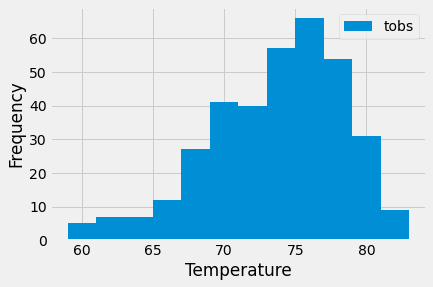

In [36]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
session.query(func.max(Msrmnts.date)).\
             filter(Msrmnts.station =='USC00519281').first()

q_date = dt.date(2017,8,18) - dt.timedelta(days=365)
#print("Query Date: ", q_date)

# Perform a query to retrieve the data and precipitation scores
results1 = session.query(Msrmnts.tobs).\
            filter(Msrmnts.date > q_date).\
            filter(Msrmnts.station =='USC00519281').\
            order_by(Msrmnts.tobs).all()
        

# Save the query results as a Pandas DataFrame and set the index to the date column
df1 = pd.DataFrame(results1, columns=['tobs']).dropna()

#df1.set_index('tobs', inplace=True)

df1.head(20)
#print(df1)


num_bins = 12
plt.hist(df1.tobs, num_bins) 
                         
  
plt.xlabel('Temperature')
plt.ylabel('Frequency')
plt.legend(["tobs"])  

plt.show()
        

# Close session

In [37]:
# Close Session
session.close()